## LSTM model za banane

### Ucitavanje neophodnih biblioteka za kreiranje LSTM modela

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

In [467]:
tf.random.set_seed(7)

### Ucitavanje i rad sa skupom podataka

In [468]:
df = pd.read_excel('../data/voce.xlsx')

In [469]:
banane_df = df[df['Naziv_proizvoda'] == 'Banane']
lstm_data = banane_df[['Nedelja', 'Kolicina']]
lstm_data

,Nedelja,Kolicina
0,03.08.2022.,10.5
8,07.04.2023.,9.0
15,14.04.2023.,9.0
22,21.04.2023.,8.0
29,28.04.2023.,8.0
...,...,...
850,01.09.2023.,4.0
862,08.09.2023.,4.0
875,15.09.2023.,4.0
885,22.09.2023.,4.0


In [470]:
lstm_data['Nedelja'] = pd.to_datetime(lstm_data['Nedelja'], format='mixed', dayfirst=True)
lstm_data.set_index('Nedelja', inplace=True)
lstm_data = lstm_data.sort_index()

C:\Users\MarijaJolovic\AppData\Local\Temp\ipykernel_12736\2285570486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_data['Nedelja'] = pd.to_datetime(lstm_data['Nedelja'], format='mixed', dayfirst=True)


### Interpoliranje podataka

In [471]:
sve_nedelje = pd.date_range(start=lstm_data.index.min(), end=lstm_data.index.max(), freq='W-FRI')
sve_nedelje

DatetimeIndex(['2022-08-05', '2022-08-12', '2022-08-19', '2022-08-26',
               '2022-09-02', '2022-09-09', '2022-09-16', '2022-09-23',
               '2022-09-30', '2022-10-07',
               ...
               '2024-05-17', '2024-05-24', '2024-05-31', '2024-06-07',
               '2024-06-14', '2024-06-21', '2024-06-28', '2024-07-05',
               '2024-07-12', '2024-07-19'],
              dtype='datetime64[ns]', length=103, freq='W-FRI')

In [472]:
def proveri_preskocene_nedelje(df):
    nedostajuce_nedelje = sve_nedelje[~sve_nedelje.isin(df.index)]

    if not nedostajuce_nedelje.empty:
        print("Preskočene nedelje u beleženju količine:")
        print(nedostajuce_nedelje)
    else:
        print("Nema preskočenih nedelja u beleženju količine.")

proveri_preskocene_nedelje(lstm_data)

Preskočene nedelje u beleženju količine:
DatetimeIndex(['2022-08-05', '2022-08-12', '2022-09-02', '2022-12-23',
               '2022-12-30', '2023-03-24', '2023-07-21', '2023-07-28',
               '2023-08-04', '2023-10-20', '2023-12-29', '2024-02-09',
               '2024-02-23', '2024-03-01', '2024-03-08', '2024-04-05',
               '2024-04-12', '2024-04-19', '2024-04-26', '2024-05-03',
               '2024-05-10', '2024-05-17', '2024-05-31'],
              dtype='datetime64[ns]', freq=None)


In [473]:
lstm_data = lstm_data.reindex(sve_nedelje)
lstm_data.index.name = 'Nedelja'
print(lstm_data)
print(lstm_data.isna().sum())

            Kolicina
Nedelja             
2022-08-05       NaN
2022-08-12       NaN
2022-08-19       3.0
2022-08-26       3.0
2022-09-02       NaN
...              ...
2024-06-21       7.0
2024-06-28       7.0
2024-07-05       7.0
2024-07-12       7.0
2024-07-19       7.0

[103 rows x 1 columns]
Kolicina    23
dtype: int64


In [474]:
lstm_data.fillna(0, inplace=True)
print(lstm_data)
print(lstm_data.isna().sum())

            Kolicina
Nedelja             
2022-08-05       0.0
2022-08-12       0.0
2022-08-19       3.0
2022-08-26       3.0
2022-09-02       0.0
...              ...
2024-06-21       7.0
2024-06-28       7.0
2024-07-05       7.0
2024-07-12       7.0
2024-07-19       7.0

[103 rows x 1 columns]
Kolicina    0
dtype: int64


In [475]:
lstm_data.loc['2022-08-05', 'Kolicina'] = 10.5

In [476]:
def popuni_nedostajuce_vrednosti(df):
    new_df = df.copy()
    
    new_df['Kolicina'] = new_df['Kolicina'].mask(new_df['Kolicina'] == 0).interpolate(method='linear')

    new_df['Kolicina'] = new_df['Kolicina'].bfill()
    
    return new_df

In [477]:
lstm_data_no_na = popuni_nedostajuce_vrednosti(lstm_data)
lstm_data_no_na[lstm_data_no_na["Kolicina"]==0]

,Kolicina
Nedelja,


In [478]:
lstm_data[lstm_data['Kolicina']==0].count()

Kolicina    23
dtype: int64

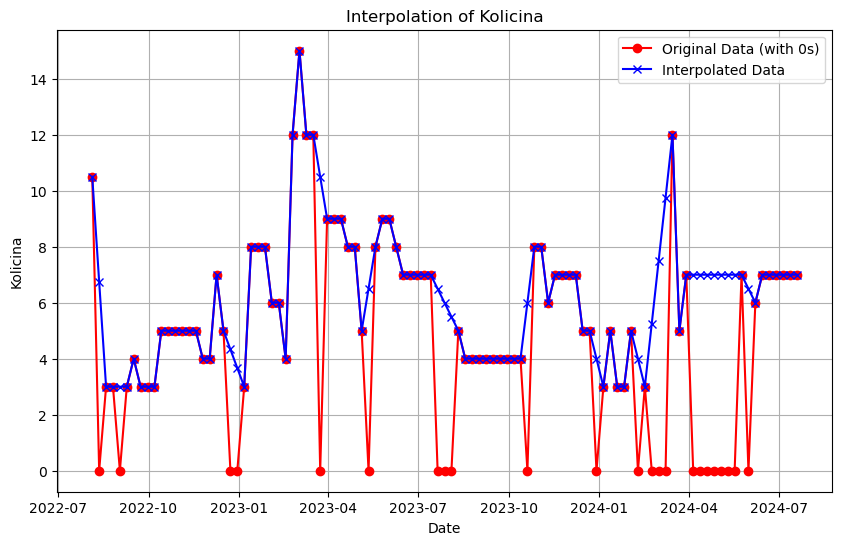

In [479]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_data.index, lstm_data['Kolicina'], marker='o', label='Original Data (with 0s)', color='red')
plt.plot(lstm_data_no_na.index, lstm_data_no_na['Kolicina'], marker='x', label='Interpolated Data', color='blue')
plt.title('Interpolation of Kolicina')
plt.xlabel('Date')
plt.ylabel('Kolicina')
plt.legend()
plt.grid()
plt.show()

In [480]:
lstm_data = lstm_data_no_na

### Skaliranje podataka

In [481]:
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data['Skalirana_kolicina'] = scaler.fit_transform(lstm_data[['Kolicina']])
lstm_data

,Kolicina,Skalirana_kolicina
Nedelja,,
2022-08-05,10.50,0.625000
2022-08-12,6.75,0.312500
2022-08-19,3.00,0.000000
2022-08-26,3.00,0.000000
2022-09-02,3.00,0.000000
...,...,...
2024-06-21,7.00,0.333333
2024-06-28,7.00,0.333333
2024-07-05,7.00,0.333333


In [482]:
train_data = lstm_data[lstm_data.index < '2024-04-01'].sort_values('Nedelja')
test_data = lstm_data[lstm_data.index >= '2024-04-01'].sort_values('Nedelja')
train_data.shape , test_data.shape

((87, 2), (16, 2))

### Kreiranje sekvenci

In [483]:
lstm_data[['Skalirana_kolicina']].shape

(103, 1)

In [484]:
def kreiraj_sekvence(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i: (i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [485]:
look_back = 1

In [486]:
print(lstm_data[['Skalirana_kolicina']].values.shape)

(103, 1)


In [487]:
X_train, y_train = kreiraj_sekvence(train_data[['Skalirana_kolicina']].values, look_back)
X_test, y_test = kreiraj_sekvence(test_data[['Skalirana_kolicina']].values, look_back=1)

In [488]:
X_train.shape, X_test.shape

((86, 1), (15, 1))

### Refaktorisanje ulazne promenljive X za LSTM 

(broj_uzoraka, vremenski_korak, broj_karakteristika)

In [489]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Kreiranje LSTM modela

In [490]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [491]:
model = Sequential()
model.add(LSTM(50, input_shape = (look_back, 1)))
model.add(Dense(1))

c:\Users\MarijaJolovic\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [492]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [493]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
86/86 - 1s - 13ms/step - loss: 0.0586
Epoch 2/100
86/86 - 0s - 2ms/step - loss: 0.0320
Epoch 3/100
86/86 - 0s - 2ms/step - loss: 0.0289
Epoch 4/100
86/86 - 0s - 1ms/step - loss: 0.0266
Epoch 5/100
86/86 - 0s - 1ms/step - loss: 0.0248
Epoch 6/100
86/86 - 0s - 2ms/step - loss: 0.0234
Epoch 7/100
86/86 - 0s - 2ms/step - loss: 0.0224
Epoch 8/100
86/86 - 0s - 2ms/step - loss: 0.0218
Epoch 9/100
86/86 - 0s - 2ms/step - loss: 0.0214
Epoch 10/100
86/86 - 0s - 2ms/step - loss: 0.0211
Epoch 11/100
86/86 - 0s - 2ms/step - loss: 0.0210
Epoch 12/100
86/86 - 0s - 2ms/step - loss: 0.0209
Epoch 13/100
86/86 - 0s - 2ms/step - loss: 0.0209
Epoch 14/100
86/86 - 0s - 1ms/step - loss: 0.0208
Epoch 15/100
86/86 - 0s - 2ms/step - loss: 0.0208
Epoch 16/100
86/86 - 0s - 2ms/step - loss: 0.0208
Epoch 17/100
86/86 - 0s - 2ms/step - loss: 0.0208
Epoch 18/100
86/86 - 0s - 2ms/step - loss: 0.0208
Epoch 19/100
86/86 - 0s - 2ms/step - loss: 0.0208
Epoch 20/100
86/86 - 0s - 1ms/step - loss: 0.0208
Epoch 21

### Performanse modela

In [494]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [495]:
train_predict

array([[0.53136533],
       [0.2971893 ],
       [0.08052582],
       [0.08052582],
       [0.08052582],
       [0.08052582],
       [0.13638923],
       [0.08052582],
       [0.08052582],
       [0.08052582],
       [0.19368048],
       [0.19368048],
       [0.19368048],
       [0.19368048],
       [0.19368048],
       [0.19368048],
       [0.13638923],
       [0.13638923],
       [0.31229725],
       [0.19368048],
       [0.15533058],
       [0.11760655],
       [0.08052582],
       [0.37348777],
       [0.37348777],
       [0.37348777],
       [0.25233835],
       [0.25233835],
       [0.13638923],
       [0.629062  ],
       [0.82985026],
       [0.629062  ],
       [0.629062  ],
       [0.53136533],
       [0.43583676],
       [0.43583676],
       [0.43583676],
       [0.37348777],
       [0.37348777],
       [0.19368048],
       [0.28215945],
       [0.37348777],
       [0.43583676],
       [0.43583676],
       [0.37348777],
       [0.31229725],
       [0.31229725],
       [0.312

In [496]:
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

In [497]:
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [498]:
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('RMSE na trening skupu : %.2f' %(train_rmse))

RMSE na trening skupu : 1.71


In [499]:
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('RMSE na test skupu : %.2f' %(test_rmse))

RMSE na test skupu : 0.36


### Vizulizacija rezultata modela

In [503]:
lstm_data = lstm_data.sort_index()

In [507]:
train_size = len(train_predict)
trainPredictPlot = np.empty_like(lstm_data[['Skalirana_kolicina']])  # Shape should match lstm_data, e.g., (N, 2)
trainPredictPlot[:, :] = np.nan  

trainPredictPlot[look_back:train_size + look_back, 0] = train_predict[:, 0]

In [508]:
test_size = len(test_predict)
testPredictPlot = np.empty_like(lstm_data[['Skalirana_kolicina']])  # Shape should match lstm_data, e.g., (N, 2)
testPredictPlot[:, :] = np.nan  

testPredictPlot[train_size + (look_back * 2) :train_size + (look_back * 2) + 1 + test_size, 0] = test_predict[:, 0]

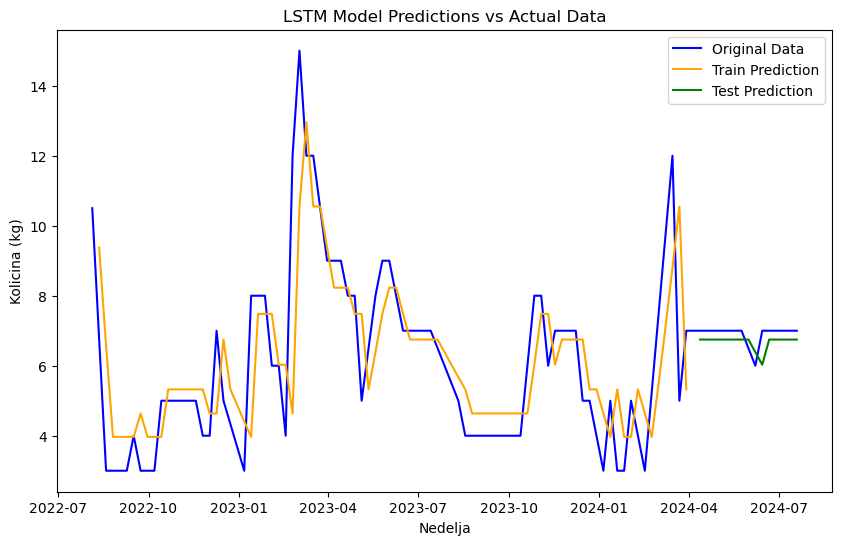

In [509]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_data.index, scaler.inverse_transform(lstm_data[['Skalirana_kolicina']]), label="Original Data", color='blue')

plt.plot(lstm_data.index[look_back:train_size + look_back], trainPredictPlot[look_back:train_size + look_back, 0], label="Train Prediction", color='orange')

plt.plot(lstm_data.index[train_size + (look_back * 2) :train_size + (look_back * 2) + 1 + test_size], 
         testPredictPlot[train_size + (look_back * 2) :train_size + (look_back * 2) + 1 + test_size, 0], 
         label="Test Prediction", color='green')

plt.title('LSTM Model Predictions vs Actual Data')
plt.xlabel('Nedelja')
plt.ylabel('Kolicina (kg)')
plt.legend()
plt.show()